In [6]:
from molmap.model import RegressionEstimator, MultiClassEstimator, MultiLabelEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from chembench import dataset
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from molmap import MolMap
from molmap import feature

def Rdsplit(df, random_state = 888, split_size = [0.8, 0.1, 0.1]):
    base_indices = np.arange(len(df)) 
    base_indices = shuffle(base_indices, random_state = random_state) 
    nb_test = int(len(base_indices) * split_size[2]) 
    nb_val = int(len(base_indices) * split_size[1]) 
    test_idx = base_indices[0:nb_test] 
    valid_idx = base_indices[(nb_test):(nb_test+nb_val)] 
    train_idx = base_indices[(nb_test+nb_val):len(base_indices)] 
    print(len(train_idx), len(valid_idx), len(test_idx)) 
    return train_idx, valid_idx, test_idx 

In [7]:
data = dataset.load_BACE()

total samples: 1513


## Pre-fit your molmap object 

In [8]:
mp1 = MolMap(ftype='descriptor',metric='cosine',)
mp1.fit(verbose=0, method='umap', min_dist=0.1, n_neighbors=15,)

2021-04-24 09:16:45,881 - INFO - [bidd-molmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-04-24 09:16:48,708 - INFO - [bidd-molmap] - Finished


In [9]:
bitsinfo = feature.fingerprint.Extraction().bitsinfo
flist = bitsinfo[bitsinfo.Subtypes.isin(['PubChemFP'])].IDs.tolist()
mp2 = MolMap(ftype = 'fingerprint', fmap_type = 'scatter', flist = flist) # 
mp2.fit(method = 'umap',  min_dist = 0.1, n_neighbors = 15, verbose = 0)

2021-04-24 09:16:53,896 - INFO - [bidd-molmap] - Applying naive scatter feature map...
2021-04-24 09:16:53,904 - INFO - [bidd-molmap] - Finished


## Extract Fmaps

In [10]:
X1 = mp1.batch_transform(data.x)
X2 = mp2.batch_transform(data.x)

100%|##########| 1513/1513 [00:49<00:00, 30.60it/s]


In [11]:
Y = pd.get_dummies(data.df['Class']).values
Y.shape

(1513, 2)

In [12]:
train_idx, valid_idx, test_idx  = Rdsplit(data.df, random_state = 888)
trainX = (X1[train_idx], X2[train_idx])
validX = (X1[valid_idx], X2[valid_idx])
testX = (X1[test_idx], X2[test_idx])

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

1211 151 151


In [13]:
# define your model, note that if your task is a multi-label problem, you should use MultiLabelEstimator
clf = MultiClassEstimator(n_outputs=trainY.shape[1], 
                          fmap_shape1 = X1.shape[1:],
                          fmap_shape2 = X2.shape[1:],
                          metric='ROC', 
                          dense_layers = [128, 64],  gpuid = 0) 

MultiClassEstimator(gpuid='0')


In [14]:
# fit your model
clf.fit(trainX, trainY, validX, validY )

epoch: 0001, loss: 0.6898 - val_loss: 0.6794; auc: 0.7948 - val_auc: 0.7536                                                                                                    
epoch: 0002, loss: 0.6759 - val_loss: 0.6679; auc: 0.8105 - val_auc: 0.7770                                                                                                    
epoch: 0003, loss: 0.6627 - val_loss: 0.6561; auc: 0.8193 - val_auc: 0.7896                                                                                                    
epoch: 0004, loss: 0.6497 - val_loss: 0.6459; auc: 0.8232 - val_auc: 0.7969                                                                                                    
epoch: 0005, loss: 0.6418 - val_loss: 0.6328; auc: 0.8292 - val_auc: 0.8012                                                                                                    
epoch: 0006, loss: 0.6276 - val_loss: 0.6213; auc: 0.8391 - val_auc: 0.8125                                             

MultiClassEstimator(gpuid='0')

## plot training history

<AxesSubplot:>

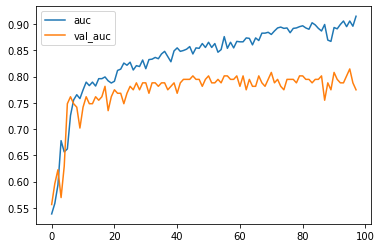

In [15]:
pd.DataFrame(clf.history.history)[['accuracy', 'val_accuracy']].rename(columns={'accuracy':'auc', 'val_accuracy':'val_auc'}).plot()

<AxesSubplot:>

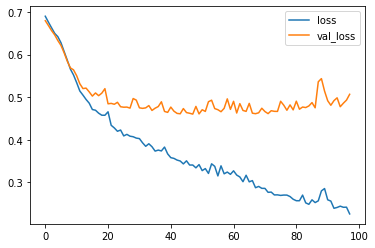

In [16]:
pd.DataFrame(clf.history.history)[['loss', 'val_loss']].plot()

In [17]:
print('Best epochs: %.2f, Best loss: %.2f' % (clf._performance.best_epoch, clf._performance.best))

Best epochs: 47.00, Best loss: 0.46


# performance on  test set

In [18]:
auc = clf.score(testX, testY)

In [19]:
auc

0.8942959001782531

In [20]:
df_pred = pd.DataFrame([testY[:, 0], clf.predict_proba(testX)[:,0]]).T
df_pred.columns=['y_true', 'y_pred_prob']

In [21]:
df_pred.head(5)

,y_true,y_pred_prob
0,1.0,0.959249
1,0.0,0.421290
2,1.0,0.967951
3,1.0,0.875520
4,0.0,0.137767


<AxesSubplot:>

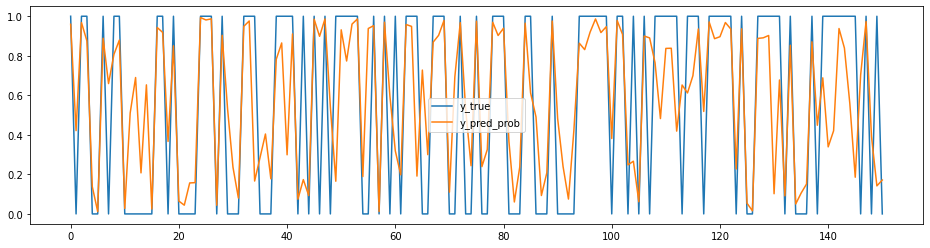

In [22]:
df_pred.plot(figsize=(16, 4))

In [23]:
df_pred.corr()

,y_true,y_pred_prob
y_true,1.000000,0.689067
y_pred_prob,0.689067,1.000000
